## Estimating flags similarity



In [167]:
import os

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial import distance

To-DO:
1. Clusters
2. Name correlation

In [168]:
def plot_flags(indexes):
    if len(indexes) == 1:
        
        plt.imshow(flags[indexes[0]])
        plt.xlabel(countries[indexes[0]])
        plt.xticks([])
        plt.yticks([])
        return
    
    fig, ax = plt.subplots(1, len(indexes))
    for i, axi in zip(indexes, ax):
        axi.imshow(flags[i])
        axi.set_xlabel(countries[i])
        axi.set_xticks([])
        axi.set_yticks([])

In [169]:
def eval_cophenetic_correlation(histograms, verbose=False):
    methods = ['single','complete','average','weighted','centroid','median','ward']
    metrics = ['euclidean','minkowski','cityblock','seuclidean','sqeuclidean','cosine','correlation',
               'hamming','jaccard','chebyshev','canberra','braycurtis','mahalanobis','yule',
               'matching','dice','kulsinski','rogerstanimoto','russellrao','sokalmichener','sokalsneath','wminkowski']
    
    best_coph = 0
    best_combo = ['','']
    total_combos = len(methods)*len(metrics)
    skipped = 0
    for method in methods:
        for metric in metrics:
            try:
                Z = linkage(histograms, method=method, metric=metric, optimal_ordering=False)
            except:
                if verbose:
                    print(f'Error for {method} x {metric}')
                skipped+=1
                continue
            coph, _ = cophenet(Z, distance.pdist(histograms))
            if coph > best_coph:
                best_coph = coph
                best_combo = [method, metric]
                
    print(f'Best cophenetic correlation = {best_coph}, obtained with method "{best_combo[0]}" and metric "{best_combo[1]}"')
    print(f'Failed {skipped} combos out of {total_combos}')

## Loading flags

In [170]:
# Source = http://flagpedia.net/download
folder = 'flags'
countries = {}
flags = []

for i, file in enumerate(os.listdir(folder)):
    countries[i] = os.path.splitext(file)[0].upper() # Save name abbreviation in dictionary
    flag = Image.open(os.path.join(folder, file)).convert("RGB")
    flags.append(flag)

C:\Users\Administrator\Anaconda3\lib\site-packages\PIL\Image.py:930: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


## Computing vector coordinates for flags

I start byt segmenting te flag several times, and the taking the normalized average quantities of red, green, and blue for each segment. 

In the example that follows, the flag of Andorra is divided in 9 pieces, and the average red, green, and blues of each segmented are shown above. It can be seen that blue is the dominant color in the first column (3rd value = 0.57), red in the third column (1st value = 0.85) and red and green (yellow) in the middle column (1st value [0.84-0.97] and 2nd value [0.61-0.86]. 

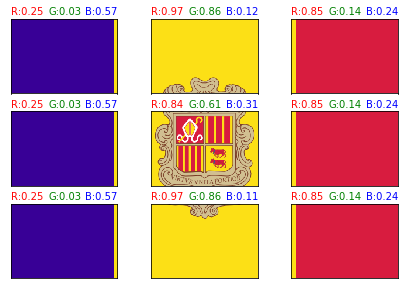

In [171]:
samplesY, samplesX = 3,3

img = np.array(flags[0])
strideY = img.shape[0] // samplesY
strideX = img.shape[1] // samplesX
        
subs = []
flag_vect = []
for i in range(samplesY):
    for j in range(samplesX):
        sub = img[i*strideY:(i+1)*strideY, j*strideX:(j+1)*strideX, :]
        subs.append(sub)
        flag_vect.append([sub[:,:,c].mean()/255 for c in range(3)])

fig, ax = plt.subplots(3,3)
for sub, axi, vect in zip(subs, ax.reshape(-1), flag_vect):
    axi.imshow(sub)      
    axi.text(0,1.05,f'R:{np.round(vect[0], 2)}', color='r', transform=axi.transAxes)
    axi.text(0.35,1.05,f'G:{np.round(vect[1], 2)}', color='g', transform=axi.transAxes)
    axi.text(0.7,1.05,f'B:{np.round(vect[2], 2)}', color='b', transform=axi.transAxes)
    axi.set_xticks([])
    axi.set_yticks([])
plt.tight_layout()

This operation yields a vector of 27 numbers, that can be used to characterize the color "coordinates" of the flag.

I've encapsulated this logic in the **Vectorize()** function. Given any image, it will computes such vector for a specified number of horizontal and vertical slices.

In [172]:
def vectorize(image, slicesY=3, slicesX=3):
        
    img = np.array(image)
    strideY = img.shape[0] // slicesY
    strideX = img.shape[1] // slicesX
        
    vector = []
    for i in range(slicesY):
        for j in range(slicesX):
            for channel in range(3):
                sub = img[i*strideY:(i+1)*strideY, j*strideX:(j+1)*strideX, channel]
                vector.append(sub.mean())
                
    return np.array(vector)/255

In [173]:
andorra_vector = vectorize(flags[0],3 ,3)
print(np.round(andorra_vector, 2))

[0.25 0.03 0.57 0.97 0.86 0.12 0.85 0.14 0.24 0.25 0.03 0.57 0.84 0.61
 0.31 0.85 0.14 0.24 0.25 0.03 0.57 0.97 0.86 0.11 0.85 0.14 0.24]


You can see that these numbers are exactly the same as those in the picture above.

## Using flag vectors to compare flag similitude

I can get a different vectors for another flag, and then compare their similitude by estimating the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the two flags. 

In the example below I compute the difference between the Andorra flag and that of Romania and Estonia. We expect the first pair to be closer (more similar) than the second. 

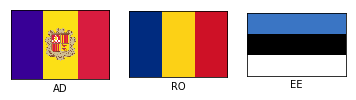

In [174]:
plot_flags([0, 147, 50])

In [175]:
romania_vector = vectorize(flags[147], 3, 3)
estonia_vector = vectorize(flags[50], 3, 3)
print('Romania Vector: ', np.round(romania_vector, 2))
print('Estonia Vector: ', np.round(estonia_vector, 2))

Romania Vector:  [0.   0.17 0.5  0.99 0.82 0.09 0.81 0.07 0.15 0.   0.17 0.5  0.99 0.82
 0.09 0.81 0.07 0.15 0.   0.17 0.5  0.99 0.82 0.09 0.81 0.07 0.15]
Estonia Vector:  [0.23 0.46 0.77 0.23 0.46 0.77 0.23 0.46 0.77 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99]


In [176]:
print('Andorra-Romania distance:', distance.euclidean(andorra_vector, romania_vector))
print('Andorra-Estonia distance:', distance.euclidean(andorra_vector, estonia_vector))

Andorra-Romania distance: 0.6523038805266951
Andorra-Estonia distance: 2.861025120616211


It works!

In [178]:
vectors = []
for flag in flags:
    vectors.append(vectorize(flag, 3, 3))

In [181]:
#eval_cophenetic_correlation(vectors)

In [182]:
# generate the linkage matrix
Z = linkage(vectors, method='ward', metric='euclidean', optimal_ordering=True)
c, _ = cophenet(Z, distance.pdist(vectors))
c

0.5165482295029137

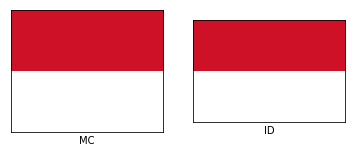

In [183]:
ind = np.array(Z[0][:2], dtype=np.int)
plot_flags(ind)

C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


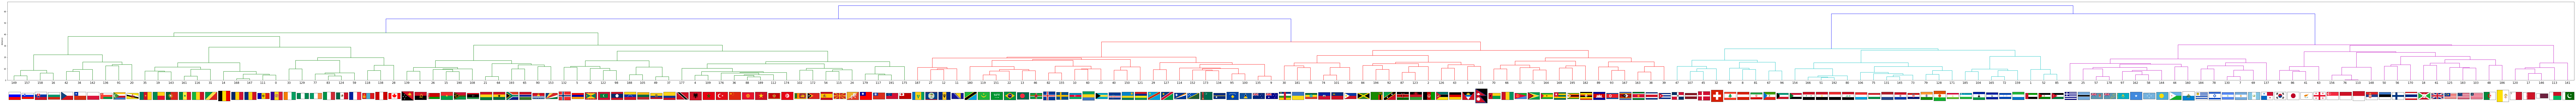

In [9]:
items = 196
item0 = 0

fig = plt.figure(figsize=(items,8))
axplot = fig.add_axes([0.0,0.25,1,0.75])

plt.ylabel('distance')
dend = dendrogram(Z, leaf_rotation=0., leaf_font_size=16.)
plt.xlim([item0*10,item0*10+items*10])


length = 1/items
spacing = 0.1*length

for k in range(items):
    axicon = fig.add_axes([k*length+spacing,0,length-spacing,0.20])
    axicon.imshow(flags[int(dend['ivl'][k+item0])])
    axicon.set_xticks([])
    axicon.set_yticks([])
#fig.savefig('test.png')

fig.show()

In [10]:
distances = []
pairs = []
for i, h1 in enumerate(histograms[:-1]):
    for j, h2 in enumerate(histograms[i+1:]):
        distances.append(distance.cityblock(h1, h2))
        pairs.append([i,i+1+j])
        
print(len(distances))
distances = np.array(distances)
pairs = np.array(pairs)
#distance.euclidean(histograms[0], histograms[1])

19110


In [11]:
#np.mean(distances)
sort = np.argsort(distances)
sorted_pairs = pairs[sort]

In [12]:
sorted_pairs[:5]

array([[ 76, 110],
       [ 51, 166],
       [147, 168],
       [ 21,  64],
       [ 51, 192]])

## Finding most similar flags

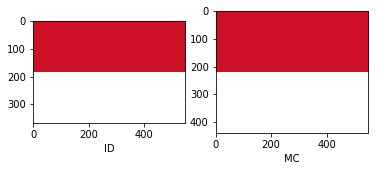

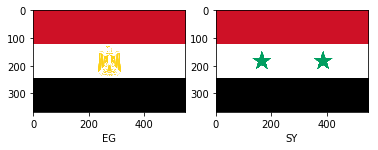

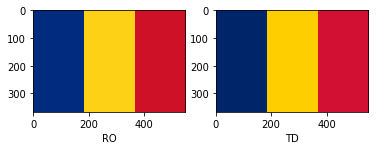

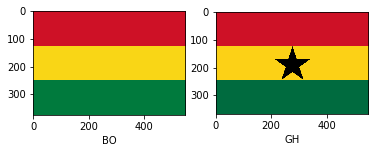

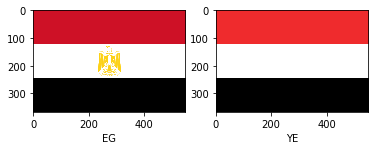

In [13]:
for pair in sorted_pairs[:5]:
    plot_flags(flags, pair)

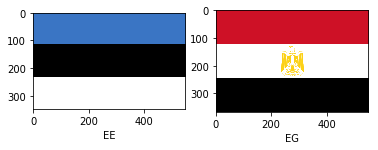

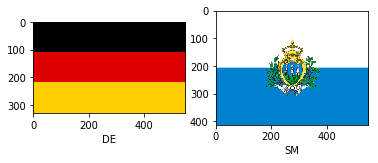

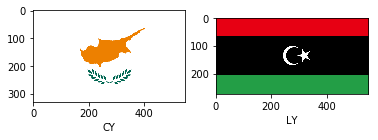

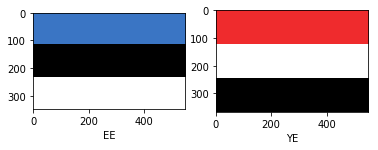

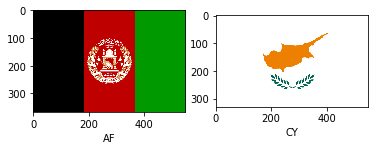

In [14]:
for pair in sorted_pairs[-5:]:
    plot_flags(flags, pair)

In [15]:
countries[143]

'pt'

In [16]:
indexes_interest = []
for i, (p1, p2) in enumerate(pairs):
    if p1 == 143 or p2 == 143:
        indexes_interest.append(i)
len(indexes_interest)

195

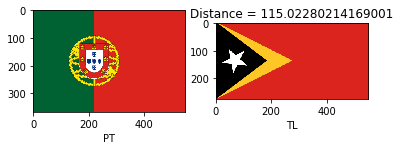

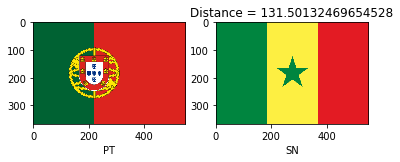

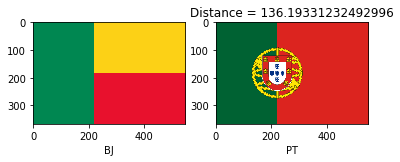

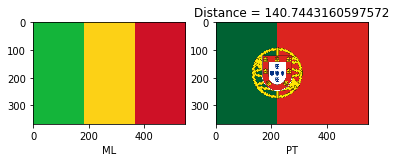

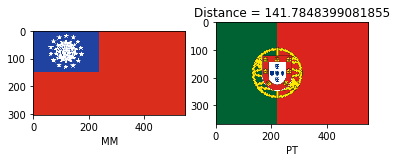

In [17]:
pt_comparisons = distances[indexes_interest] 
pt_pairs = pairs[indexes_interest]
sort = np.argsort(pt_comparisons)
sorted_comparisons = pt_comparisons[sort]
sorted_pairs = pt_pairs[sort]

for pair, dist in zip(sorted_pairs[:5], sorted_comparisons[:5]):
    plot_flags(flags, pair)
    plt.title(f'Distance = {dist}')

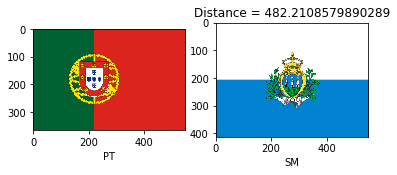

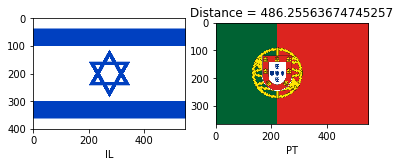

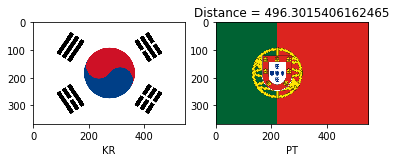

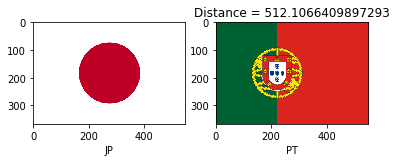

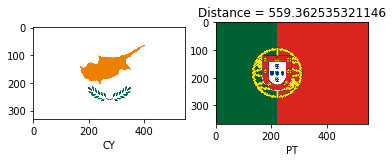

In [18]:
for pair, dist in zip(sorted_pairs[-5:], sorted_comparisons[-5:]):
    plot_flags(flags, pair)
    plt.title(f'Distance = {dist}')

In [19]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [20]:
len(histograms[0])

867